In [1]:
from scipy import signal
import numpy as np
from scipy.fftpack import fft, ifft
import pandas as pd

import matplotlib
matplotlib.use('nbagg')
from pylab import rcParams
rcParams['figure.figsize'] = 9, 4
import matplotlib.pyplot as plt
import scipy

%load_ext autoreload
%autoreload 2
import sys
import copy

from pyha import Hardware, simulate, sims_close, Complex, resize, hardware_sims_equal
from pathlib import Path
from data import load_iq
from skimage.exposure import exposure

def imshow(im):
    from skimage.exposure import exposure
    p2, p98 = np.percentile(im, (2, 98))
    im = exposure.rescale_intensity(im, in_range=(p2, p98))

    
    plt.imshow(im, interpolation='nearest', aspect='auto', origin='lower')
    plt.tight_layout()
    plt.show()
    
    
def snr(pure, noisy):
    sig_pow = np.nanmean(np.abs(pure))
    error = np.array(pure) - np.array(noisy)
    err_pow = np.nanmean(np.abs(error))
    
    snr_db = 20*np.log10(sig_pow/err_pow)
    return snr_db

from under_construction.fft.bit_reversal_fftshift import bit_reversed_indexes
from under_construction.fft.fft_core import R2SDFSFIX, R2SDF
from under_construction.fft.packager import DataWithIndex, unpackage, package

def show_freqz(taps):
    w, h = scipy.signal.freqz(taps)
    fig, ax1 = plt.subplots(1, 1)
    plt.title('Digital filter frequency response')
    ax1.plot(w / np.pi, 20 * np.log10(abs(h)), 'b')
    ax1.set_ylabel('Amplitude [dB]', color='b')
    ax1.set_xlabel('Frequency')
    plt.grid()
    ax2 = ax1.twinx()
    angles = np.unwrap(np.angle(h))
    ax2.plot(w / np.pi, angles, 'g')
    ax2.set_ylabel('Angle (radians)', color='g')
    ax2.axis('tight')
    plt.tight_layout()
    plt.show()
    
def show_plot():
    plt.tight_layout()
    plt.grid()
    if plt.gca().get_legend_handles_labels() != ([], []):
        plt.legend()
    plt.show()
    
def bit_reverse(x, n_bits):
    return int(np.binary_repr(x, n_bits)[::-1], 2)

def bit_reversed_indexes(N):
    return [bit_reverse(i, int(np.log2(N))) for i in range(N)]

from pyha import Hardware, simulate, sims_close, Complex, Sfix
from pyha.common.float import *
# Float.use_float16 = True
# Float.use_float16 = False

from mpmath import mp 
results = {}


# FFT

In [2]:
from pyha.common.shift_register import ShiftRegister
from under_construction.fft.packager import DataWithIndex, unpackage, package

def W(k, N):
    """ e^-j*2*PI*k*n/N, argument k = k * n """
    return np.exp(-1j * (2 * np.pi / N) * k)

class StageR2SDF(Hardware):
    def __init__(self, fft_size):
        self.FFT_SIZE = fft_size
        self.FFT_HALF = fft_size // 2

        self.CONTROL_MASK = (self.FFT_HALF - 1)
        self.shr = ShiftRegister([ComplexFloat() for _ in range(self.FFT_HALF)])

#         self.TWIDDLES = [Complex(W(i, self.FFT_SIZE), 0, -8, overflow_style='saturate', round_style='round') for i in range(self.FFT_HALF)]
        self.TWIDDLES = [ComplexFloat(W(i, self.FFT_SIZE)) for i in range(self.FFT_HALF)]
        # self.TWIDDLES = [W(i, self.FFT_SIZE) for i in range(self.FFT_HALF)]

    def butterfly(self, in_up, in_down, twiddle):
        up = in_up + in_down
        down_part = in_up - in_down
        down = down_part * twiddle
        return up, down

    def main(self, x, control):
        if not (control & self.FFT_HALF):
            self.shr.push_next(x)
            return self.shr.peek()
        else:
            twid = self.TWIDDLES[control & self.CONTROL_MASK]
            up, down = self.butterfly(self.shr.peek(), x, twid)

            # if self.FFT_HALF > 4:
            #     down >>= 1
            #     up >>= 1

            self.shr.push_next(down)
            return up


class R2SDF(Hardware):
    def __init__(self, fft_size):
        self.FFT_SIZE = fft_size

        self.n_bits = int(np.log2(fft_size))
        self.stages = [StageR2SDF(2 ** (pow + 1)) for pow in reversed(range(self.n_bits))]

        # Note: it is NOT correct to use this gain after the magnitude/abs operation, it has to be applied to complex values
        self.GAIN_CORRECTION = 2 ** (0 if self.n_bits - 3 < 0 else -(self.n_bits - 3))
        self.DELAY = (fft_size - 1) + 1  # +1 is output register

        self.out = DataWithIndex(ComplexFloat(), 0)

    def main(self, x):
        # #execute stages
        out = x.data
        for stage in self.stages:
            out = stage.main(out, x.index)

        self.out.data = out
        self.out.index = (x.index + self.DELAY + 1) % self.FFT_SIZE
        self.out.valid = x.valid
        return self.out

    def model_main(self, x):
        ffts = np.fft.fft(x)

        # apply bit reversing ie. mess up the output order to match radix-2 algorithm
        # from under_construction.fft.bit_reversal import bit_reversed_indexes
        def bit_reverse(x, n_bits):
            return int(np.binary_repr(x, n_bits)[::-1], 2)

        def bit_reversed_indexes(N):
            return [bit_reverse(i, int(np.log2(N))) for i in range(N)]

        rev_index = bit_reversed_indexes(self.FFT_SIZE)
#         for i, _ in enumerate(ffts):
#             ffts[i] = ffts[i][rev_index]
        ffts = ffts[rev_index]
        # apply gain control (to avoid overflows in hardware)
        ffts *= self.GAIN_CORRECTION

        return ffts
    
def postprocess(x):
    pyh = x
    pyh = pyh[bit_reversed_indexes(fft_size)]
    pyh = np.fft.fftshift(pyh)
    pyh = [complex(x) for x in pyh]
#     pyh = np.abs(pyh)
    pyh = pyh * np.conjugate(pyh)
#     pyh = pyh / pyh.max()
    return pyh.real

    a = 20 * np.log10(pyh 
#                       + 0.0000000000000000000001
                     ) # add small number to avoid div by 0
    return a

import numpy as np
def load_iq(file):
    f = np.fromfile(open(str(file)), dtype=np.complex64)
    return f

In [3]:
fft_size = 1024 * 2 * 2 * 2

# # mavic remote close
# iq = load_iq('/run/media/gaspar/maxtor/measurement 13.03.2018/mavic_remote/qdetector_20180313150128083939_close/1520946087.9236_fs=20000000.0_bw=20000000.0_fc=2410000000.0_d=0_g=033000.raw')
# offset = 91 #small peak
# offset = 220 # large + small

# Mavic tele close
# iq = load_iq('/run/media/gaspar/maxtor/measurement 13.03.2018/mavic_tele/qdetector_20180313144154381793_close_20m_regular/1520944916.4658_fs=20000000.0_bw=20000000.0_fc=2452000000.0_d=0_g=033000.raw')
# offset = 1 

# mavic tele far
iq = load_iq('/run/media/gaspar/maxtor/measurement 13.03.2018/mavic_tele/qdetector_20180313122024455464_far_10m_regular/1520936424.9351_fs=20000000.0_bw=20000000.0_fc=2410000000.0_d=2_g=063015.raw')

sig = iq.reshape(-1, fft_size)
print(sig.shape)
sig *= np.hanning(fft_size)
sig = sig.flatten()
print(sig.shape)
# offset = 1 

# sl_iq = iq[fft_size * offset:fft_size * (offset + 1)]
# print(sl_iq.shape)
# sig = sl_iq * np.hanning(fft_size)

# for offset in range(1, 64):
#     print(offset)
#     sl_iq = iq[fft_size * offset:fft_size * (offset + 1)]
#     print(sl_iq.shape)
#     sig = sl_iq * np.hanning(fft_size)
#     plt.magnitude_spectrum(sig, window=matplotlib.mlab.window_none, scale='dB')
#     plt.grid()
#     plt.show()


(236, 8192)
(1933312,)


<IPython.core.display.Javascript object>


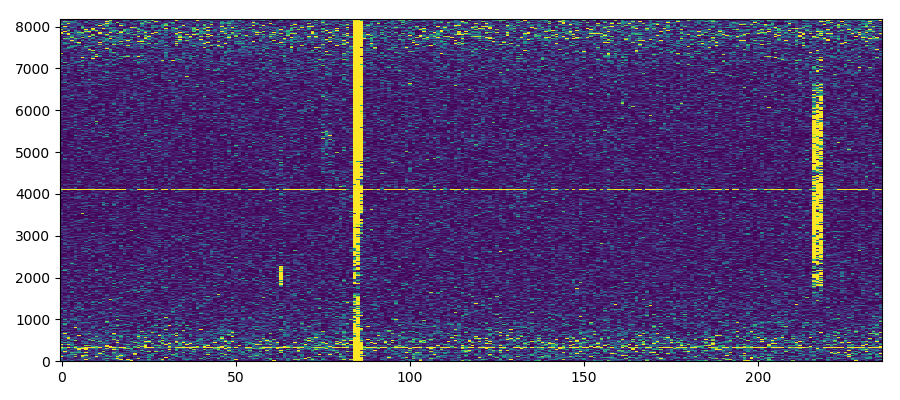

In [6]:
# fiq = 'under_construction.fft.fft_core.test_realsig'
iq = load_iq('/run/media/gaspar/maxtor/measurement 13.03.2018/mavic_tele/qdetector_20180313122024455464_far_10m_regular/1520936425.4884_fs=20000000.0_bw=20000000.0_fc=2431000000.0_d=0_g=063015.raw')

fft_points = fft_size
freq_axis_avg_decimation = 64
_, _, spectro_out = signal.spectrogram(iq, 1, nperseg=fft_points, return_onesided=False, detrend=False,
                               noverlap=0, window='hann')

# fftshift
spectro_out = np.roll(spectro_out, fft_points//2, axis=0)

# avg decimation
# x = np.split(spectro_out, len(spectro_out) // freq_axis_avg_decimation)
# golden_output = np.average(x, axis=1)

# imshow(golden_output)
imshow(spectro_out)


In [27]:
import pickle
with open('/home/gaspar/Documents/1520936452.2426_fs=20000000.0_bw=20000000.0_fc=2431000000.0_d=0_g=033000.raw.pickle', 'rb') as f:
    data = pickle.load(f)
    
model = np.array([postprocess(np.array(x)) for x in data['MODEL']])
pyha = np.array([postprocess(np.array(x)) for x in data['PYHA']])

In [28]:
snr(data['MODEL'], data['PYHA'])

12.50193094185573

13.59639604231573


/usr/lib/python3.6/site-packages/matplotlib/pyplot.py:537: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


<IPython.core.display.Javascript object>


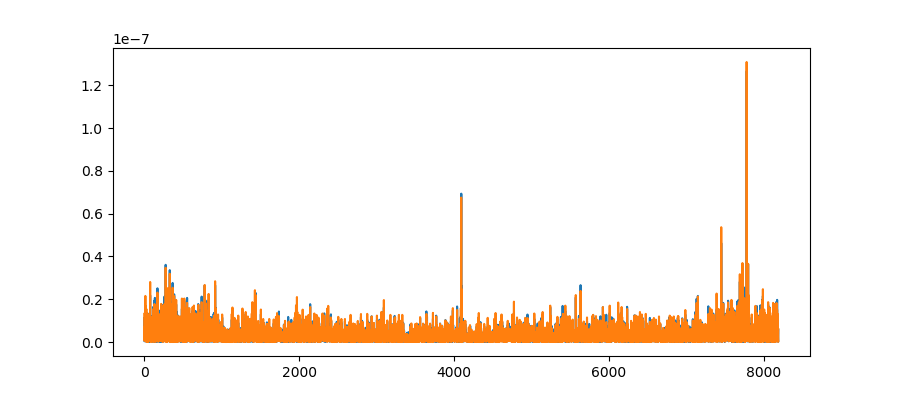

In [31]:
print(snr(model, pyha))
plt.plot(model[0])
plt.plot(pyha[0])
plt.show()

In [64]:
freq_axis_avg_decimation = 64
x = np.split(model.T, len(model.T) // freq_axis_avg_decimation)
model_dec = np.average(x, axis=1)

x = np.split(pyha.T, len(pyha.T) // freq_axis_avg_decimation)
pyha_dec = np.average(x, axis=1)

/usr/lib/python3.6/site-packages/matplotlib/pyplot.py:537: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


<IPython.core.display.Javascript object>


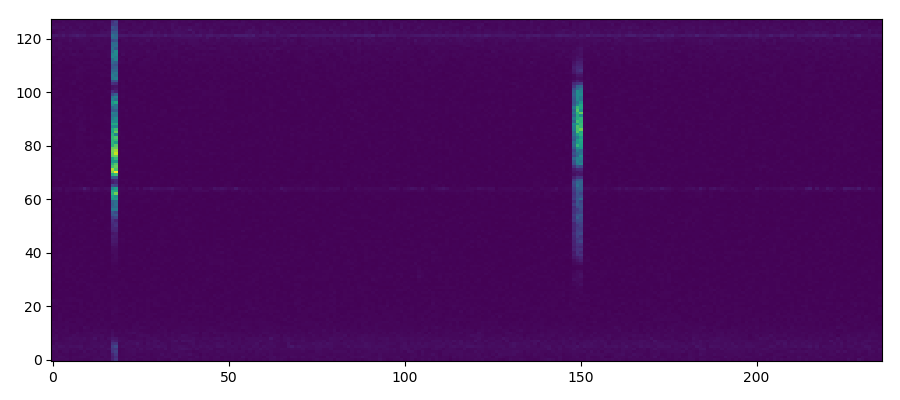

In [65]:
plt.imshow(model_dec, interpolation='nearest', aspect='auto', origin='lower')
plt.tight_layout()
plt.show()

/usr/lib/python3.6/site-packages/matplotlib/pyplot.py:537: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


<IPython.core.display.Javascript object>


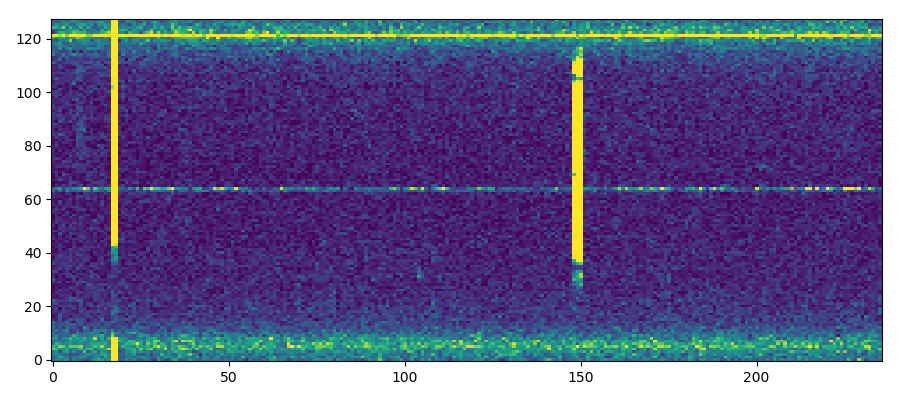

<IPython.core.display.Javascript object>


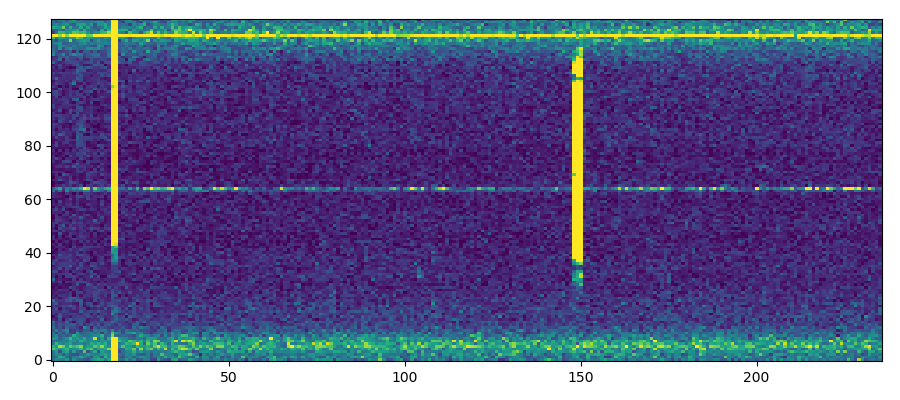

In [66]:
imshow(model_dec)
imshow(pyha_dec)

21.70628830506577


/usr/lib/python3.6/site-packages/matplotlib/pyplot.py:537: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


<IPython.core.display.Javascript object>


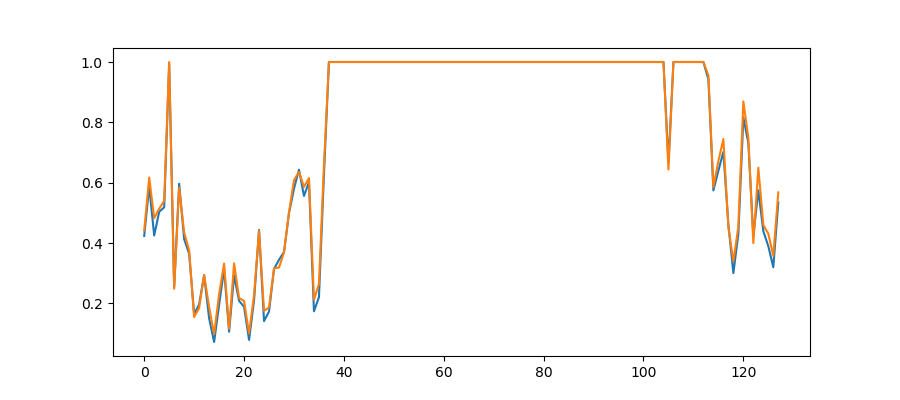

In [70]:
p2, p98 = np.percentile(model_dec, (2, 98))
model_re = exposure.rescale_intensity(model_dec, in_range=(p2, p98))

p2, p98 = np.percentile(pyha_dec, (2, 98))
pyha_re = exposure.rescale_intensity(pyha_dec, in_range=(p2, p98))

print(snr(model_re, pyha_re))
plt.plot(model_re.T[149])
plt.plot(pyha_re.T[149])
plt.show()

12.83115394696328


/usr/lib/python3.6/site-packages/matplotlib/pyplot.py:537: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


<IPython.core.display.Javascript object>


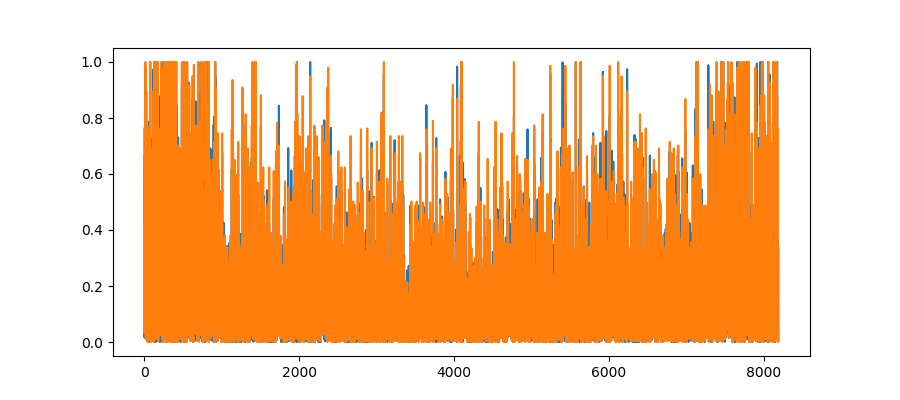

In [54]:
p2, p98 = np.percentile(model, (2, 98))
model_re = exposure.rescale_intensity(model, in_range=(p2, p98))

p2, p98 = np.percentile(pyha, (2, 98))
pyha_re = exposure.rescale_intensity(pyha, in_range=(p2, p98))

print(snr(model_re, pyha_re))
plt.plot(model_re[0])
plt.plot(pyha_re[0])
plt.show()

/usr/lib/python3.6/site-packages/matplotlib/pyplot.py:537: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


<IPython.core.display.Javascript object>


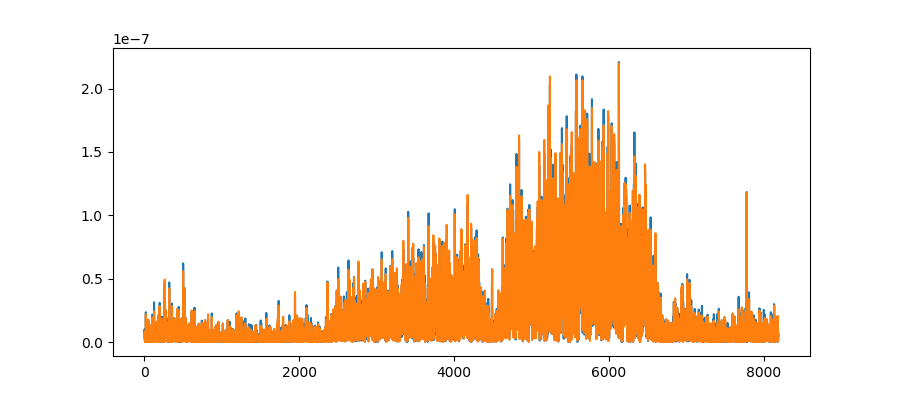

In [71]:
i = 148
plt.plot(pyha[i])
plt.plot(model[i])
plt.show()

/usr/lib/python3.6/site-packages/matplotlib/pyplot.py:537: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


<IPython.core.display.Javascript object>


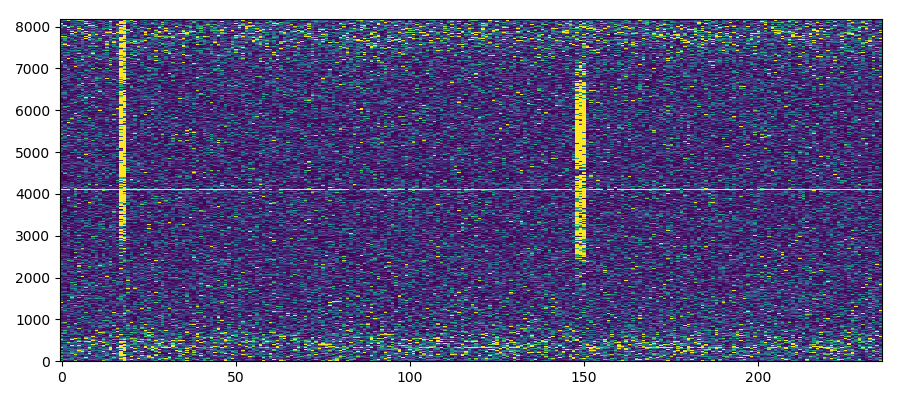

In [35]:
imshow(pyha.T)

/usr/lib/python3.6/site-packages/matplotlib/pyplot.py:537: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


<IPython.core.display.Javascript object>


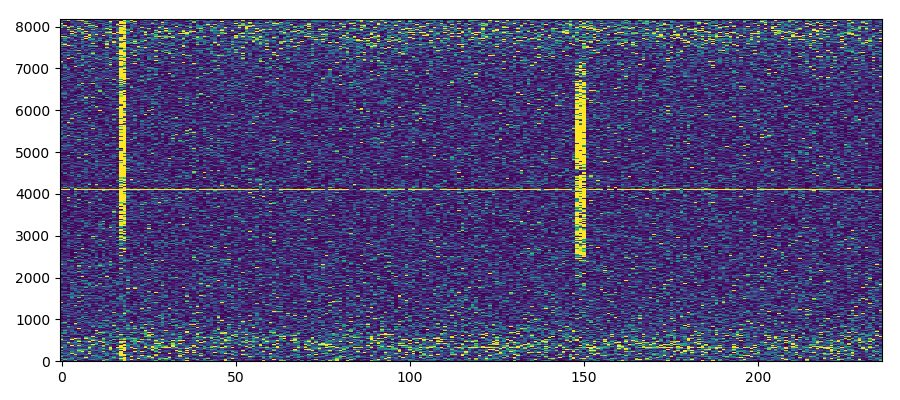

In [36]:
imshow(model.T)

/usr/lib/python3.6/site-packages/matplotlib/pyplot.py:537: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


<IPython.core.display.Javascript object>


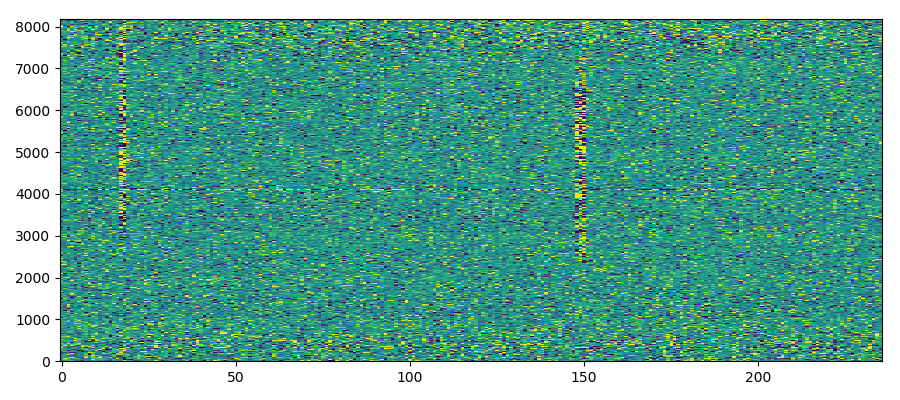

In [39]:
imshow((model - pyha).T)

In [ ]:
plt.plot(fix_res[216])
plt.legend()
# plt.ylim([-130, 10])
plt.grid()
plt.show()

In [ ]:
for i in range(64):
    model = postprocess(sig[i])
    fixx = postprocess(fix[i])
    plt.plot(model)
    plt.plot(fixx)
    plt.legend()
    # plt.ylim([-130, 10])
    plt.grid()
    plt.show()


In [ ]:

plt.plot(sf)
plt.plot(pre)
plt.legend()
# plt.ylim([-130, 10])
plt.grid()
plt.show()

In [ ]:
fft_points = fft_size
freq_axis_avg_decimation = 64
_, _, spectro_out = signal.spectrogram(iq, 1, nperseg=fft_points, return_onesided=False, detrend=False,
                               noverlap=0, window='hann')

# fftshift
spectro_out = np.roll(spectro_out, fft_points//2, axis=0)

# avg decimation
x = np.split(spectro_out, len(spectro_out) // freq_axis_avg_decimation)
golden_output = np.average(x, axis=1)

imshow(golden_output)

In [ ]:
plt.plot(sig)
plt.show()

plt.magnitude_spectrum(sig, window=matplotlib.mlab.window_none, scale='dB')
plt.grid()
plt.show()

In [ ]:

with force_format(radix=32, exponent_bits=3, fractional_bits=14):
    dut = R2SDF(fft_size)
    sims = simulate(dut, sig, input_types=[ComplexFloat()], simulations=['MODEL', 'PYHA'], output_callback=unpackage, input_callback=package)
    results['Float64'] = postprocess(np.array([complex(x) for x in sims['MODEL']]))
    results['Radix32'] = postprocess(np.array([complex(x) for x in sims['PYHA'][0]]))


In [ ]:
results['Radix32']

In [ ]:
plt.plot(results['Radix32'])
plt.legend()
plt.grid()
plt.show()

In [ ]:
for key, val in results.items():
    plt.plot(val, label=key)
plt.legend()
# plt.ylim([-130, 10])
plt.grid()
plt.show()

In [ ]:
for key, val in results.items():
    plt.plot(results['Float64'] - val, label=key)
plt.legend()
plt.grid()
plt.show()

for key, val in results.items():
    print(f'{key} SNR: {snr(results["Float64"], val)} dB')
#     plt.plot(results['Float64'] - val, label=key)